In [1]:
import pickle as pkl
from pprint import pprint

import autosklearn.regression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model, tree
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from xgboost import XGBRegressor
from datetime import datetime
import optuna

import seaborn as sns
sns.set_style("whitegrid")


/home/maxb/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
to_drop = [
        "woda_chłodząca_do_kolektor_kz9",
        "woda_chłodząca_do_kolektor_kz10",
        "woda_chłodząca_do_kolektor_kz11",
        "woda_chłodząca_do_kolektor_kz12",
        "woda_powrotna_kolektora_kz8",
        "woda_powrotna_kolektora_kz9",
        "woda_powrotna_kolektora_kz10",
        "woda_powrotna_kolektora_kz11",
        "woda_powrotna_kolektora_kz12",
        "woda_powrotna_kolektora_kz13",
        "woda_powrotna_kolektora_kz15",
        "temp._wody_zasil.obieg_pz_1",
        "went_rf02_odcz_zad_obrotów",
        "went_rf03_odcz_zad_obrotów",
        "temp2_pod_2_warstwą_wymurówki",
        "temp3_pod_2_warstwą_wymurówki",
        "temp4_pod_2_warstwą_wymurówki",
        "temp5_pod_2_warstwą_wymurówki",
        "temp6_pod_2_warstwą_wymurówki",
        "temp7_pod_2_warstwą_wymurówki",
        "temp8_pod_2_warstwą_wymurówki",
        "temp9_pod_2_warstwą_wymurówki",
        "temp10_pod_2_warstwą_wymurówki",
        "temp11_pod_2_warstwą_wymurówki",
        "temp12_pod_2_warstwą_wymurówki",
        "temp13_pod_2_warstwą_wymurówki",
        "temp14_pod_2_warstwą_wymurówki",
        "temp16_pod_2_warstwą_wymurówki",
        "temp17_pod_2_warstwą_wymurówki",
        "temp18_pod_2_warstwą_wymurówki",
        "temp19_pod_2_warstwą_wymurówki",
        "temp20_pod_2_warstwą_wymurówki",
        "temp21_pod_2_warstwą_wymurówki",
        "temp22_pod_2_warstwą_wymurówki",
        "temp23_pod_2_warstwą_wymurówki",
        "temp24_pod_2_warstwą_wymurówki",
        "temp_na_kol_kan_1-34",
        "temp_na_kol_kan_35-68",
        "reg_nadawy_koncentratu_liw2",
    ]

In [3]:
def do_eval(model, order):
    valid = pd.read_feather("test_full.fth")
    for i in range(24):
        valid["hour_" + str(i)] = valid.czas.dt.hour.map(lambda x: int(x == i))
    for i in range(7):
        valid["wday_" + str(i)] = valid.czas.dt.weekday.map(lambda x: int(x == i))
    features = list(set(valid.columns) - ({"index", "czas", "temp_zuz"} | set(to_drop)))
    target_name = "temp_zuz"

    errors = []
    target = []
    pred = []

    prev_temp_zuz = 1303.7838813542785
    # for idx, row in tqdm(valid.iterrows(), total=len(valid)):
    for idx, row in valid.iterrows():
        x, t = row[features], row[target_name]
        # t = t_normalizer.transform([[t]])
        x["prev_temp_zuz"] = prev_temp_zuz
        x = x[order].to_numpy().astype(np.float32)
        # x = x_normalizer.transform(x)
        t_ = model.predict(x[None, :])
        # t_ = t_normalizer.inverse_transform(t_)
        target.append(t)
        pred.append(t_)
        if not np.isnan(t):
            # print(idx, t_, t)
            errors.append((t_.item() - t) ** 2.0)

        prev_temp_zuz = t_ if np.isnan(t) else t

    return np.mean(errors), target, pred


In [7]:
dataset = pd.read_feather("interp_dataset_full.fth")
dataset = dataset[dataset.czas < datetime.fromisoformat("2021-12-14 04:45:00")]
for i in range(24):
    dataset["hour_" + str(i)] = dataset.czas.dt.hour.map(lambda x: int(x == i))
for i in range(7):
    dataset["wday_" + str(i)] = dataset.czas.dt.weekday.map(lambda x: int(x == i))
features = sorted(list(set(dataset.columns) - ({"czas", "temp_zuz",} | set(to_drop))))
print(features)
target = ["temp_zuz"]
x, t = dataset[features].to_numpy(), dataset[target].to_numpy()
# x_normalizer = StandardScaler()
# x = x_normalizer.fit_transform(x)
# t_normalizer = StandardScaler()
# t = t_normalizer.fit_transform(t)
x_train, x_test, t_train, t_test = train_test_split(
    x, t, train_size=0.9, random_state=42
)
print(len(x_train), len(x_test))

print("features:", len(features))

def objective(trial):
    # param = {
    #     "n_estimators": trial.suggest_int("n_estimators", 50, 300),
    #     "max_depth": trial.suggest_int("max_depth", 6, 10),
    #     "eta": trial.suggest_float('alpha', 0.1, 0.5),
    #     "subsample": trial.suggest_float('subsample', 0.7, 1.0),
    #     "colsample_bytree": trial.suggest_float('colsample_bytree', 0.8, 1.0),
    # }
    param = {
        "activation": trial.suggest_categorical('activation', ['relu']),
        
        "solver": trial.suggest_categorical('solver', ['sgd', 'adam']),
    }
    num_layers = trial.suggest_int("num_layers", 1, 1)
    layers = [trial.suggest_int("hidden_layer_sizes", 30, 100)]
    if num_layers <= 2:
        layers.append(trial.suggest_int("hidden_layer_sizes1", 30, 100))
    if num_layers <= 3:
        layers.append(trial.suggest_int("hidden_layer_sizes2", 30, 100))
    
    # model = XGBRegressor(**param)

    # model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model = MLPRegressor(hidden_layer_sizes=layers, **param)
    model.fit(x_train, t_train)
    # model.save_model("models/xgb_full_6.model")
    # pkl.dump(model, open("models/xgb_full_6.pkl", "wb"))
    
    pred = model.predict(x_test)
    print("Easier eval MSE =", np.mean((pred - t_test) ** 2.0))
    loss, *_ = do_eval(model, features)
    print("True eval MSE =", loss)
    return loss if loss == loss else 1000 
    
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

['hour_0', 'hour_1', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_2', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'prażona_mieszanina_koncentratów_hg1_fe', 'prażona_mieszanina_koncentratów_hg1_sog', 'prev_temp_zuz', 'prob_corg', 'prob_fe', 'prob_s', 'reg_koncentrat_prazony_liw3', 'reg_nadawy_koncentratu_liw1', 'reg_pyl_zwrot_liw4', 'sumaryczna_moc_cieplna_odebrana_całkowita', 'temp._wody_zasil.obieg_pz_2', 'temp15_pod_2_warstwą_wymurówki', 'temp1_pod_2_warstwą_wymurówki', 'wday_0', 'wday_1', 'wday_2', 'wday_3', 'wday_4', 'wday_5', 'wday_6', 'went_rf01_odcz_zad_obrotów', 'woda_chłodząca_do_kolektor_kz13', 'woda_chłodząca_do_kolektor_kz15', 'woda_chłodząca_do_kolektor_kz7', 'woda_chłodząca_do_kolektor_kz8', 'woda_powrotna_kolektora_kz7']
113850 12651
features: 50


In [9]:
model = MLPRegressor()
model.fit(x_train, t_train)
pred = model.predict(x_test)
print(x_train.shape)
print(pred.shape)
print(t_test.shape)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(113850, 19)
(12651,)
(12651, 1)
Easier eval MSE = 2.9485060368091696
True eval MSE = 330.71114734228274


In [ ]:
from sklearn import svm
model = svm.SVR()
model.fit(x_train, t_train)
with open("svr.pkl", "wb") as file:
        pkl.dump(model, file)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features,)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [8]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train, t_train)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: (array([1190.        , 1190.04166667, 1190.08333333, ..., 1335.16666667,
       1335.66666667, 1338.        ]),)

In [9]:
from sklearn import linear_model
model = linear_model.LassoLars(alpha=.1, normalize=False)
model.fit(x_train, t_train)
with open("lasso_lars.pkl", "wb") as file:
        pkl.dump(model, file)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

Easier eval MSE = 0.2911990151173035
True eval MSE = 47.35704185934579


In [8]:
model = linear_model.BayesianRidge(n_iter=1500)
model.fit(x_train, t_train)
with open("bayesian_ridge.pkl", "wb") as file:
        pkl.dump(model, file)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Easier eval MSE = 0.27383434030549925
True eval MSE = 45.20448563527602


In [9]:
from sklearn.linear_model import TweedieRegressor
model = TweedieRegressor(power=1, alpha=0.5, link='log')
model.fit(x_train, t_train)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/_loss/glm_distribution.py:323: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y / y_pred) - y + y_pred)
/home/maxb/miniconda3/li

Easier eval MSE = 183.41045153189452
True eval MSE = 64.21346913085321


In [16]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(n_estimators=25)
model.fit(x_train, t_train)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Easier eval MSE = 2.0467847184941244
True eval MSE = 55.964925974561176


In [5]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=31, learning_rate=0.1, max_depth=4, random_state=0, 
)
model.fit(x_train, t_train)
pred = model.predict(x_test)
with open("grad_boost_reg.pkl", "wb") as file:
        pkl.dump(model, file)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Easier eval MSE = 0.6021702844274672
True eval MSE = 43.39881840408523


In [38]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=27, learning_rate=0.1, max_depth=5, random_state=0, 
)
model.fit(x_train, t_train)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Easier eval MSE = 0.9230702231992233
True eval MSE = 44.300783965718374


In [12]:
import tpot

model = tpot.TPOTRegressor(
    scoring='neg_mean_absolute_error',
                          cv=5,
                          n_jobs=24, verbosity=1) #number of folds in StratifiedKFold
model.fit(x_train, t_train)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)
with open("tpot.pkl", "wb") as file:
        pkl.dump(model, file)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maxb/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/maxb/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/maxb/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index w



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: XGBRegressor(input_matrix, learning_rate=0.5, max_depth=10, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Easier eval MSE = 0.13673841289462918
True eval MSE = 78.88939993496307


PicklingError: Can't pickle <class 'tpot.operator_utils.XGBRegressor__learning_rate'>: attribute lookup XGBRegressor__learning_rate on tpot.operator_utils failed

In [12]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(max_iter=100)
model.fit(x_train, t_train)
pred = model.predict(x_test)
print("Easier eval MSE =", np.mean((pred[:, None] - t_test) ** 2.0))
loss, *_ = do_eval(model, features)
print("True eval MSE =", loss)

/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
/home/maxb/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Easier eval MSE = 0.29563115904448617
True eval MSE = 50.30084134730144


In [13]:
import json
json.dump(study.best_params, open("xgb_best_params.json", "w"))

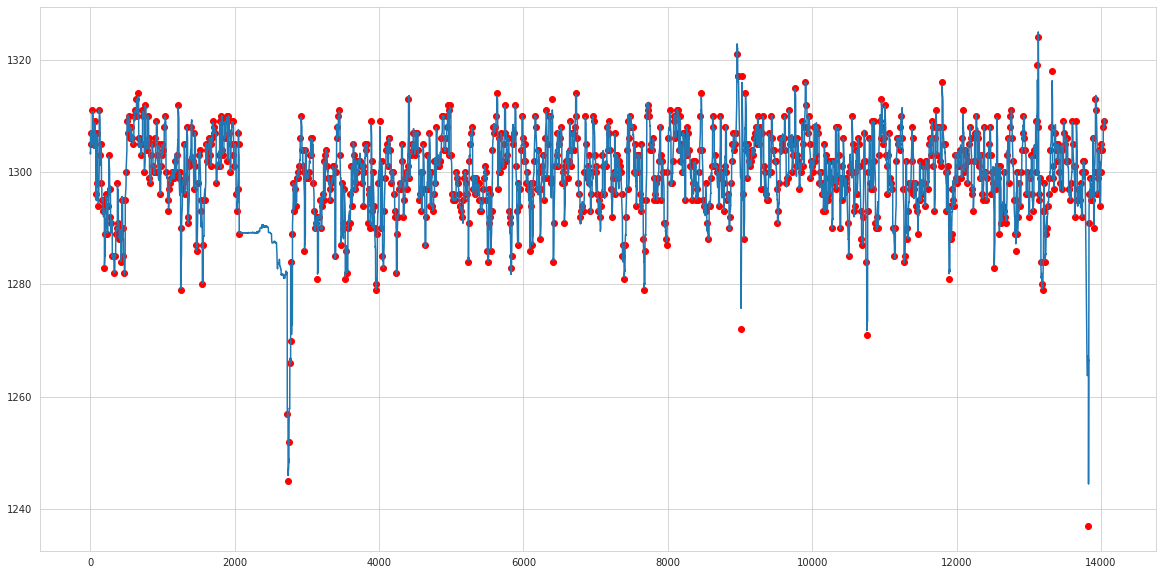

In [4]:
fig = plt.figure(figsize=(20, 10))
plt.plot(target, "ro")
plt.plot(pred)
plt.show()

In [5]:
from mx_stack.db import db_connection
from mx_stack.settings import *

postgres_host = "10.0.0.1"
postgres_port = 7001

postgres_uri = (
    f"postgresql://{postgres_user}:{postgres_passwd}@{postgres_host}:{postgres_port}/"
)
dbcon = db_connection(postgres_uri + postgres_db)
df = pd.DataFrame({"target": target, "pred": [p[0] for p in pred]})
df.to_sql("xgboost_6", dbcon)
df

target         pred
0         NaN  1303.632080
1         NaN  1303.656616
2         NaN  1303.655762
3      1307.0  1303.709595
4         NaN  1307.040649
...       ...          ...
14050     NaN  1309.614624
14051     NaN  1309.564697
14052     NaN  1309.596802
14053     NaN  1309.421753
14054     NaN  1309.191650

[14055 rows x 2 columns]